In [4]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as st
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18, 6
import seaborn as sns
import sklearn
from sklearn.ensemble.forest import RandomForestRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import operator 
import psycopg2
import math
import requests
import json
from flask import jsonify
import csv
from csv import writer
from statistics import mean
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from numpy import cov
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from numpy import mean
from numpy import std
import statistics

# Fetching latest data of pollution from APi

In [8]:
url = 'https://www.numbeo.com/api/rankings_by_country_historical?api_key=r8umol7u42vvbs&section=8&fbclid=IwAR2g23utsR5KC5PvEU91RyQk8Z3DWno1BMqEL-KsbgAG43aQc-RxX4TDN0w'
response = requests.get(url)
lst = json.loads(response.text)

pollution_index = {}


for i in lst['2020']:
    
    pollution_index[i['iso3166_country_code']] = i['pollution_index']

In [9]:
len(pollution_index)

110

# Making CSV file containing pollution data

In [10]:
with open('global_pollution_index_ranking_comma.csv', 'w') as csv_file:
    csv_writer = writer(csv_file)
    headers = ['country name', 'Country_code_iso2','pollution index']
    csv_writer.writerow(headers)
    for i in lst['2020']:
        name = i['country']
        code = i['iso3166_country_code']
        entry = [name, code,pollution_index[code]]
        csv_writer.writerow(entry)


# reading total affected, deaths and recovered with active cases from api

In [2]:

url = 'http://coronavirus-tracker-api.herokuapp.com/all'
response = requests.get(url)
lst = json.loads(response.text)
url_iso2 = 'https://restcountries.eu/rest/v2/'


response_iso2 = requests.get(url_iso2)
lst_iso2 = json.loads(response_iso2.text)

latestaffected={}
latestdeath={}
latestrecovered={}
population={}
dict_iso3 = {}

for i in lst['confirmed']['locations']:
    
    latestaffected[i['country_code']] = {}
    latestdeath[i['country_code']] = {}
    latestrecovered[i['country_code']] = {}
    
for k in lst_iso2:
    population[k['alpha2Code']] = k['population']
    dict_iso3[k['alpha2Code']] = k['alpha3Code']
    

for i in lst['confirmed']['locations']:
    code = i['country_code']
    latestaffected[code] = 0

for i in lst['recovered']['locations']:
    code = i['country_code']
    latestrecovered[code] = 0

for i in lst['deaths']['locations']:
    code = i['country_code']
    latestdeath[code] = 0
    

    
for i in lst['deaths']['locations']:
    code = i['country_code']
    latestdeath[code] = latestdeath[code] + i['latest'] 

for i in lst['recovered']['locations']:
    code = i['country_code']
    latestrecovered[code] = latestrecovered[code] + i['latest']

for i in lst['confirmed']['locations']:
    code = i['country_code']
    latestaffected[code] = latestaffected[code] + i['latest']

 # making csv file containig covid datas

In [3]:
with open('countrylatestactive.csv', 'w') as csv_file:
    csv_writer = writer(csv_file)
    headers = ['Country_name', 'Country_code_iso2','population','Tot_affected','Tot_dead','Tot_recov','Affected per thousand','Active','Active_rateaff','Active_raterec','Death rate']
    csv_writer.writerow(headers)
    for i in lst['confirmed']['locations']:
        name = i['country']
        code = i['country_code']
        if code in dict_iso3:
            active = latestaffected[code]-(latestrecovered[code]+ latestdeath[code])
            entry = [name, code,population[code],latestaffected[code],latestdeath[code],latestrecovered[code],(latestaffected[code]/population[code]) * 1000, active ,(active/latestaffected[code])*100,(active/(latestrecovered[code]+active))*100, latestdeath[code]/latestaffected[code]]
            csv_writer.writerow(entry)


# Deleting duplicates

In [4]:
with open('countrylatestactive.csv','r') as in_file, open('countrylatestactive2.csv','w') as out_file:
    seen = set() # set for fast O(1) amortized lookup
    for line in in_file:
        if line in seen: continue # skip duplicate

        seen.add(line)
        out_file.write(line)

# Joining two csv files (final csv is combinedpollution.csv)

In [14]:
df1 = pd.read_csv('global_pollution_index_ranking_comma.csv')
df2 = pd.read_csv('countrylatestactive2.csv')
res = pd.merge(df1, df2,on ='Country_code_iso2',how='left')
res.to_csv('combinedpollution.csv', index=False)

# reading csv file and making scatter plot (pollution index vs total affected)

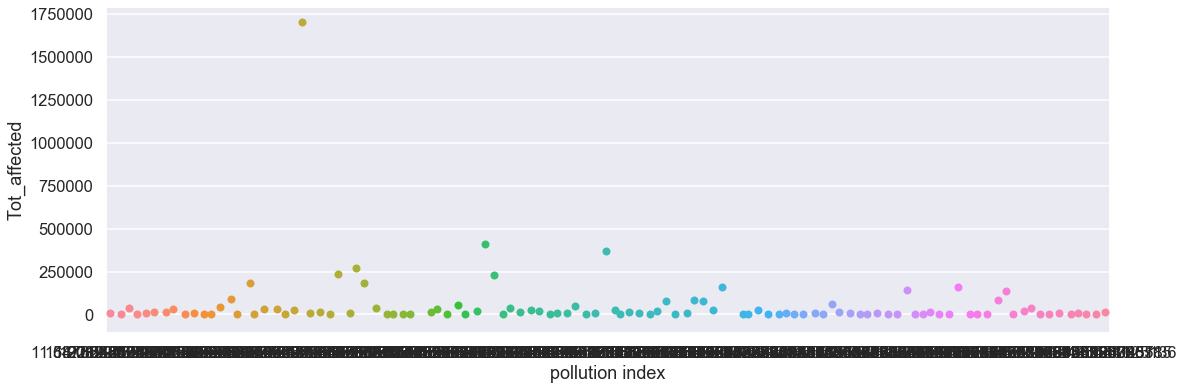

In [5]:
dataset = pd.read_csv('combinedpollution.csv')


import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
sns.set_context("talk")
#fig_dims = (20, 20)
#fig, ax = plt.subplots(figsize=fig_dims)
#sns.set_ylim(0,1750000,1000)
#plt.ylim(-1000,1750000,1000)
ax = sns.stripplot(x="pollution index", y="Tot_affected",jitter=0.25,size=8, data=dataset)

In [3]:
with open('combinedpollution.csv','r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    
    with open('affected+pollution.csv','w') as new_file1:
        fieldnames1 = ['country name','population','pollution index','Tot_affected']
        
        csv_writer1 = csv.DictWriter(new_file1, fieldnames= fieldnames1)
        csv_writer1.writeheader()
        
        for line1 in csv_reader:
            del line1['Country_code_iso2']
            del line1['Tot_recov']
            del line1['Tot_dead']
            del line1['Affected per thousand']
            del line1['Active']
            del line1['Active_rateaff']
            del line1['Active_raterec']
            del line1['Country_name']
            #print(line['CFR1'],line['CFR2'])
            #print(line1)
            csv_writer1.writerow(line1)

In [9]:

def correl(bd):
    Bd1 = bd.iloc[:,2:3]
    Bd2 = bd.iloc[:,3:4]
    
    
    X = [x[0] for x in Bd1.values.tolist()]  #list comprehension
    Y = [y[0] for y in Bd2.values.tolist()]
    print('data1: mean=%.3f stdv=%.3f' % (mean(X), std(X)))
    print('data2: mean=%.3f stdv=%.3f' % (mean(Y), std(Y)))
    print('pollution index: median=%.3f' % statistics.median(X))
    print('total affected: median=%.3f' % statistics.median(Y))
    
    
    #print('my function pearson : %.5f' % pearson_def(X,Y))
    
    covariance = cov(X,Y)
    print('covarience value :')
    print( covariance)
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=X,y=Y,mode='markers',marker_color=Y)) # hover text goes here

    fig.update_layout(title='pollution index vs affected', xaxis=dict(title='pollution index'),yaxis=dict(title='Total # of Affected'))
    
    fig.show()
    ##pyplot.scatter(Bd1, Bd2)
    #pyplot.xlabel("temparature")
    #pyplot.ylabel("Total Affected")
    #pyplot.show()
    alpha = 0.05 #setting my significant level 5 %
    corr, r = pearsonr(X,Y)
    print('Pearsons correlation: %.3f' % corr)
   
    
    if r > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % r)
        
    else:
        print('Samples are correlated (reject H0) p=%.3f' % r)
        
        
    corr, p = spearmanr(X,Y)
    print('Spearmans correlation: %.3f' % corr)
    
    
    # interpret the significance
    
    if p > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
        
    else:
        print('Samples are correlated (reject H0) p=%.3f' % p)
       
        
    
    coef, q = kendalltau(X,Y)
    print('Kendall correlation coefficient: %.3f' % coef)
    
    # interpret the significance
    alpha = 0.05
    if q > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % q)
        
    else:
        print('Samples are correlated (reject H0) p=%.3f' % q)
        

    


In [10]:
df = pd.read_csv('affected+pollution.csv')

correl(df)

data1: mean=58.139 stdv=21.022
data2: mean=51997.157 stdv=174857.973
pollution index: median=62.808
total affected: median=8567.000
covarience value :
[[ 4.46049847e+02 -4.26830649e+05]
 [-4.26830649e+05  3.08610611e+10]]


Pearsons correlation: -0.115
Samples are uncorrelated (fail to reject H0) p=0.236
Spearmans correlation: -0.231
Samples are correlated (reject H0) p=0.016
Kendall correlation coefficient: -0.153
Samples are correlated (reject H0) p=0.019
